In [1]:
import peregrine
import sys
from peregrine._falcon4py import ffi as falcon_ffi
from peregrine._falcon4py import lib as falcon4py
from peregrine._shimmer4py import ffi as shimmer_ffi
from peregrine._shimmer4py import lib as shimmer4py
import numpy as np
import mmap
from pprint import pprint

Peregrine Assembler & SHIMMER ASMKit(0.1.2p2+4.gf6a611c.dirty)


In [2]:
f=open("../test/ecoli_K12/wd/index/seq_dataset.seqdb", "rb")
seqdb=mmap.mmap(f.fileno(), 0, flags=mmap.MAP_SHARED, prot=mmap.PROT_READ)

In [3]:
rmap = dict(zip(b"ACGT", b"TGCA"))

In [4]:
read_data = {}
with open("../test/ecoli_K12/wd/index/seq_dataset.idx") as f:
    for row in f:
        row = row.strip().split()
        rid, rname, rlen, offset = row
        rid = int(rid)
        rlen = int(rlen)
        offset = int(offset)
        read_data.setdefault(rid, {})
        read_data[rid]["name"] = rname
        read_data[rid]["length"] = rlen
        read_data[rid]["offset"] = offset

In [5]:
print(len(read_data))

4984


In [6]:
py_mmer_L0=shimmer_ffi.new("py_mmer_t *")
shimmer4py.build_shimmer_map4py(py_mmer_L0, 
                             b"../test/ecoli_K12/wd/index/seq_dataset", 
                             b"../test/ecoli_K12/wd/index/shmr-L0", 
                             1, 1, 2, 240)

py_mmer_L1=shimmer_ffi.new("py_mmer_t *")
shimmer4py.build_shimmer_map4py(py_mmer_L1, 
                             b"../test/ecoli_K12/wd/index/seq_dataset", 
                             b"../test/ecoli_K12/wd/index/shmr-L1", 
                             1, 1, 2, 240)


py_mmer_L2=shimmer_ffi.new("py_mmer_t *")
shimmer4py.build_shimmer_map4py(py_mmer_L2, 
                             b"../test/ecoli_K12/wd/index/seq_dataset", 
                             b"../test/ecoli_K12/wd/index/shmr-L2", 
                             1, 1, 2, 240)

In [7]:
# get the range of the shimmers of each in the py_mmer vector
def get_mmer_index(py_mmer):
    mmer_index = {}
    for i in range(py_mmer.mmers.n):
        mmer = py_mmer.mmers.a[i]
        rid = mmer.y >> 32
        mmer_index.setdefault(rid, [None, None])
        if mmer_index[rid][0] == None:
            mmer_index[rid][0] = i
        if mmer_index[rid][1] == None or i > mmer_index[rid][1]:
            mmer_index[rid][1] = i
    return mmer_index

In [8]:
mmer_index_L0 = get_mmer_index(py_mmer_L0)
mmer_index_L1 = get_mmer_index(py_mmer_L1)
mmer_index_L2 = get_mmer_index(py_mmer_L2)

In [9]:
rid = 0
s,e=mmer_index_L0[rid]
print(f"the range of shimmers for the read {rid} is from {s} to {e}")

the range of shimmers for the read 0 is from 1715488 to 1715868


In [10]:
basemap = {1:"A",2:"C",4:"G",8:"T"}

In [11]:
def get_shimmers_for_read(rid, mmer_index, py_mmer, mc_l=2, mc_h=240):
    kset = set()
    shimmers = []
    s,e = mmer_index[rid]
    for i in range(s,e):
        x = py_mmer.mmers.a[i].x
        y = py_mmer.mmers.a[i].y
        span = x & 0xFF
        mmer = x >> 8
        mmcount = shimmer4py.get_mmer_count(py_mmer, mmer)
        if mmcount < mc_l or mmcount > mc_h:
            continue
        rid = y >> 32
        pos_end = ((y & 0xFFFFFFFF) >> 1) + 1
        strand = y & 0x1
        
        mm_str = "{:014X}".format(mmer)
        
        s = read_data[rid]["offset"]
        e = s + read_data[rid]["length"]
        kmer =  "".join([basemap[c&0x0F] for c in seqdb[s:e][pos_end-span:pos_end]])
        
        shimmers.append( (rid, span, pos_end, strand, mmer, mm_str, kmer, mmcount) )
        kset.add(mmer)
    return shimmers, kset

In [12]:
shimmers_L0, kset_L0 = get_shimmers_for_read(rid, mmer_index_L0, py_mmer_L0)
shimmers_L1, kset_L1 = get_shimmers_for_read(rid, mmer_index_L1, py_mmer_L1)
shimmers_L2, kset_L2 = get_shimmers_for_read(rid, mmer_index_L2, py_mmer_L2)

In [13]:
print(f"L0 shimmer for read {rid}")
pprint(len(shimmers_L0))
pprint(len(shimmers_L1))
pprint(len(shimmers_L2))

L0 shimmer for read 0
325
102
32


In [14]:
shimmer_count_L0 = []
shimmer_count_L1 = []
shimmer_count_L2 = []

for rid in read_data:
    shimmers_L0, kset_L0 = get_shimmers_for_read(rid, mmer_index_L0, py_mmer_L0)
    shimmer_count_L0.append( (len(shimmers_L0),read_data[rid]["length"]/(len(shimmers_L0)-1)))
    
    shimmers_L1, kset_L1 = get_shimmers_for_read(rid, mmer_index_L1, py_mmer_L1)
    shimmer_count_L1.append( (len(shimmers_L1),read_data[rid]["length"]/(len(shimmers_L1)-1)))
    
    shimmers_L2, kset_L2 = get_shimmers_for_read(rid, mmer_index_L2, py_mmer_L2)
    shimmer_count_L2.append( (len(shimmers_L2),read_data[rid]["length"]/(len(shimmers_L2)-1)))

In [15]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np

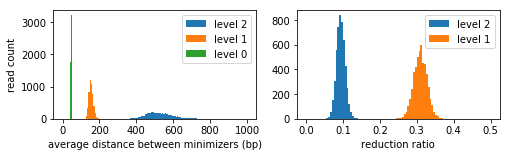

In [16]:
plt.figure(figsize=(8,2))
plt.subplot(1,2,1)
h_L2=plt.hist([x[1] for x in shimmer_count_L2], bins=150, range=(0,1000))
h_L1=plt.hist([x[1] for x in shimmer_count_L1], bins=150, range=(0,1000))
h_L0=plt.hist([x[1] for x in shimmer_count_L0], bins=150, range=(0,1000))
plt.xlabel("average distance between minimizers (bp)")
plt.ylabel("read count")
plt.legend( ("level 2","level 1", "level 0") )

plt.subplot(1,2,2)
r1_list=[]
r2_list=[]
for i in range(len(shimmer_count_L0)):
    r1 = shimmer_count_L1[i][0]/shimmer_count_L0[i][0]
    r2 = shimmer_count_L2[i][0]/shimmer_count_L0[i][0]
    r1_list.append(r1)
    r2_list.append(r2)
h2=plt.hist(r2_list, bins=100, range=(0,0.5))
h1=plt.hist(r1_list, bins=100, range=(0,0.5))
plt.xlabel("reduction ratio")
#plt.ylabel("read count")
plt.legend( ("level 2","level 1") )
#plt.subplot(2,1,2)


In [17]:
k_count = []
for rid in read_data:
    shimmers_L0, kset_L0 = get_shimmers_for_read(rid, mmer_index_L0, py_mmer_L0)
    k_count.append( (np.mean([c[-1] for c in shimmers_L0]), rid ) )

k_count.sort()
k_count[-1]

(44.69097222222222, 3621)

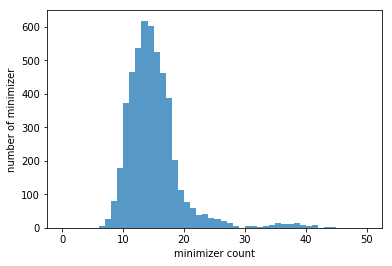

In [18]:
plt.hist( [c[0] for c in k_count], bins=50, range=(0,50), alpha=0.75 );
plt.xlabel("minimizer count");
plt.ylabel("number of minimizer");

331
100
29


Text(0.5, 0, 'position of minimizers (bp)')

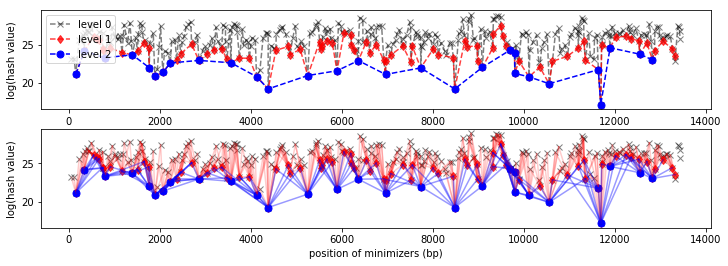

In [19]:
rid = 3621
shimmers_L0, kset_L0 = get_shimmers_for_read(rid, mmer_index_L0, py_mmer_L0, mc_l=0, mc_h=240)
shimmers_L1, kset_L1 = get_shimmers_for_read(rid, mmer_index_L1, py_mmer_L1, mc_l=0, mc_h=240)
shimmers_L2, kset_L2 = get_shimmers_for_read(rid, mmer_index_L2, py_mmer_L2, mc_l=0, mc_h=240)
pprint(len(shimmers_L0))
pprint(len(shimmers_L1))
pprint(len(shimmers_L2))

x0,y0 = list(zip(*[ (c[2], c[4]) for c in shimmers_L0]))
x0,c0 = list(zip(*[ (c[2], c[-1]) for c in shimmers_L0]))
x1,y1 = list(zip(*[ (c[2], c[4]) for c in shimmers_L1]))
x1,c1 = list(zip(*[ (c[2], c[-1]) for c in shimmers_L1]))
x2,y2 = list(zip(*[ (c[2], c[4]) for c in shimmers_L2]))
x2,c2 = list(zip(*[ (c[2], c[-1]) for c in shimmers_L2]))

plt.figure( figsize=(12,4))
plt.subplot(2,1,1)

plt.plot(np.array(x0), np.log2(y0), "kx--", alpha=0.5)
plt.plot(np.array(x1), np.log2(y1), "rd--", alpha=0.75)
plt.plot(np.array(x2), np.log2(y2), "bo--", alpha=1, markersize=7)
plt.legend( ("level 0","level 1", "level 2"),loc=2 )
plt.ylabel("log(hash value)")


plt.subplot(2,1,2)
plt.plot(np.array(x0), np.log2(y0), "kx", alpha=0.5)
plt.plot(np.array(x1), np.log2(y1), "rd", alpha=0.75)
plt.plot(np.array(x2), np.log2(y2), "bo", alpha=1, markersize=7)

x1toy1 = dict(list(zip(x1,y1)))
for i in range(len(x0)):
    x = x0[i]
    y = y0[i]
    if x in x1toy1:
        for j in range(i-1, i-6, -1):
            if j < 0:
                break
            if y0[j] > y:
                plt.plot((x0[j], x), (np.log2(y0[j]), np.log2(y)), "r-", alpha=0.2)
            else:
                break
        for j in range(i+1, i+6, 1):
            if j >= len(x0):
                break
            if y0[j] > y:
                plt.plot((x0[j], x), (np.log2(y0[j]), np.log2(y)), "r-", alpha=0.2)
            else:
                break

x2toy2 = dict(list(zip(x2,y2)))

for i in range(len(x1)):
    x = x1[i]
    y = y1[i]
    if x in x2toy2:
        for j in range(i, i-6, -1):
            if j < 0:
                break
            if y1[j] >= y:
                plt.plot((x1[j], x), (np.log2(y1[j]), np.log2(y)), "b-", alpha=0.4)
            else:
                break
        for j in range(i, i+6, 1):
            if j >= len(x1):
                break
            if y1[j] >= y:
                plt.plot((x1[j], x), (np.log2(y1[j]), np.log2(y)), "b-", alpha=0.4)
            else:
                break



plt.ylabel("log(hash value)")
plt.xlabel("position of minimizers (bp)")
#plt.ylim(-1,3)
#plt.xlim(0,5000)

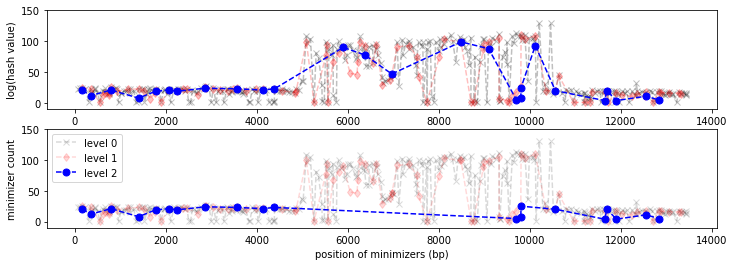

In [20]:


shimmers_L0, kset_L0 = get_shimmers_for_read(rid, mmer_index_L0, py_mmer_L0, mc_l =0, mc_h=240)
shimmers_L1, kset_L1 = get_shimmers_for_read(rid, mmer_index_L1, py_mmer_L1, mc_l =0, mc_h=240)
shimmers_L2, kset_L2 = get_shimmers_for_read(rid, mmer_index_L2, py_mmer_L2, mc_l =2, mc_h=240)

x0,y0 = list(zip(*[ (c[2], c[4]) for c in shimmers_L0]))
x0,c0 = list(zip(*[ (c[2], c[-1]) for c in shimmers_L0]))
x1,y1 = list(zip(*[ (c[2], c[4]) for c in shimmers_L1]))
x1,c1 = list(zip(*[ (c[2], c[-1]) for c in shimmers_L1]))
x2,y2 = list(zip(*[ (c[2], c[4]) for c in shimmers_L2]))
x2,c2 = list(zip(*[ (c[2], c[-1]) for c in shimmers_L2]))


plt.figure( figsize=(12,4))
#plt.xlim(10000,14000)
plt.subplot(2,1,1)
plt.plot(x0, c0, 'kx--', alpha=0.25)
plt.plot(x1, c1, 'rd--', alpha=0.25)
plt.plot(x2, c2, 'bo--', alpha=1, markersize=7)
plt.ylim(0,120)
plt.ylabel("minimizer count")
plt.xlabel("position of minimizers (bp)")
plt.ylim(-10,150)



shimmers_L0, kset_L0 = get_shimmers_for_read(rid, mmer_index_L0, py_mmer_L0, mc_l =0, mc_h=240)
shimmers_L1, kset_L1 = get_shimmers_for_read(rid, mmer_index_L1, py_mmer_L1, mc_l =0, mc_h=240)
shimmers_L2, kset_L2 = get_shimmers_for_read(rid, mmer_index_L2, py_mmer_L2, mc_l =2, mc_h=40)

x0,y0 = list(zip(*[ (c[2], c[4]) for c in shimmers_L0]))
x0,c0 = list(zip(*[ (c[2], c[-1]) for c in shimmers_L0]))
x1,y1 = list(zip(*[ (c[2], c[4]) for c in shimmers_L1]))
x1,c1 = list(zip(*[ (c[2], c[-1]) for c in shimmers_L1]))
x2,y2 = list(zip(*[ (c[2], c[4]) for c in shimmers_L2]))
x2,c2 = list(zip(*[ (c[2], c[-1]) for c in shimmers_L2]))


plt.ylabel("log(hash value)")
plt.subplot(2,1,2)
plt.plot(x0, c0, 'kx--', alpha=0.15)
plt.plot(x1, c1, 'rd--', alpha=0.15)
plt.plot(x2, c2, 'bo--', alpha=1, markersize=7)
plt.ylim(-10,150)
plt.ylabel("minimizer count")
plt.xlabel("position of minimizers (bp)")
plt.legend( ("level 0","level 1", "level 2"),loc=2 )

In [21]:
nread_ovlp = []
for rid in read_data:
    shimmers_L2, kset_L2 = get_shimmers_for_read(rid, mmer_index_L2, py_mmer_L2, mc_h=240)
    rids = set()
    n0 = shimmers_L2[0]
    for n1 in shimmers_L2[1:]:
        v = shimmer_ffi.new("mp256_v *")
        shimmer4py.get_shimmer_hits(v, py_mmer_L2, n0[4], 16)
        for i in range(v.n):
            if  (v.a[i].x1 >> 8) == n1[4]:
                rids.add(v.a[i].y0 >> 32)
        n0 = n1
    nread_ovlp.append(len(rids))

Text(0, 0.5, 'number of reads')

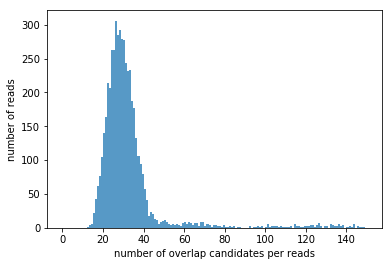

In [22]:
plt.hist(nread_ovlp, bins=150, range=(0,150), alpha=0.75);
plt.xlabel("number of overlap candidates per reads")
plt.ylabel("number of reads")

In [23]:
nread=len(read_data)
print(nread, 
      nread*nread, 
      np.sum(nread_ovlp), 
      np.sum(nread_ovlp)/nread, 
      np.sum(nread_ovlp)/(nread*nread))
print()
print("total reads sampled:", nread)
print("total pairs:", nread*(nread-1)/2)
print("total number of overlap candidates:", np.sum(nread_ovlp))
print("number of candidates per read: {:0.3f}".format(np.sum(nread_ovlp)/nread))
print("reduction from full quadratic comparison: {:0.4f}%".format(np.sum(nread_ovlp)/(nread*nread)*100))



4984 24840256 158876 31.87720706260032 0.006395908319141316

total reads sampled: 4984
total pairs: 12417636.0
total number of overlap candidates: 158876
number of candidates per read: 31.877
reduction from full quadratic comparison: 0.6396%
